- 3 lines, compare T interventions (with policy) for regular CBM, out version, shindy version and plot num interv cs acc
- incorporate smooth path updates regularization
- communicate clearly who glues everything together and ... + how everything is exactly ended

- gru and other architecture implement -> but this means always having their version and our version

- plotting
- saving of the model post training

NOTES:

- currently incorporated data creation
- adjust device
- final plot and ...


CLEARLY MARK WHERE THE CODE COMES FROM

- incorporate test stuff
- incorporate simple setup for ablations
- incroporate placebo test thingy
- save current version and upgrade to multi lstm setting
- make everything modular and split across files in the end
- glue together with prior stages and post stages, since currently only working on realignment network and we keep all components indep

RESOLVE:

- what exactly do we do, what do we try to show
- what ablations do we want (other models besides LSTM?)
- do we do hyperpar optim?
- we probably just show a small loss in acc compared ot the regular realignemt one which I copied and stripped to take as starting point


Using device: cpu
Data generation successful on attempt 1.
Training samples: 10000, Validation samples: 2000
Selected model type: LSTM
LSTM model initialized.
Model weights initialized.
No adapter path provided. Skipping adapter loading.
Optimizer and scheduler initialized.
Loss function initialized.
Epoch 1: Improved validation loss to 0.6238.
Epoch [1/20], Train Loss: 0.6238, Val Loss: 0.6238, Time: 16.14s
Epoch 2: Validation loss did not improve (0.6239).
Epoch [2/20], Train Loss: 0.6238, Val Loss: 0.6239, Time: 15.94s
Epoch 3: Validation loss did not improve (0.6239).
Epoch [3/20], Train Loss: 0.6238, Val Loss: 0.6239, Time: 16.44s
Epoch 4: Validation loss did not improve (0.6239).
Epoch [4/20], Train Loss: 0.6238, Val Loss: 0.6239, Time: 16.07s
Epoch 5: Validation loss did not improve (0.6239).
Epoch [5/20], Train Loss: 0.6238, Val Loss: 0.6239, Time: 18.97s
Epoch 6: Validation loss did not improve (0.6239).
Epoch [6/20], Train Loss: 0.6238, Val Loss: 0.6239, Time: 19.07s
Epoch 7:

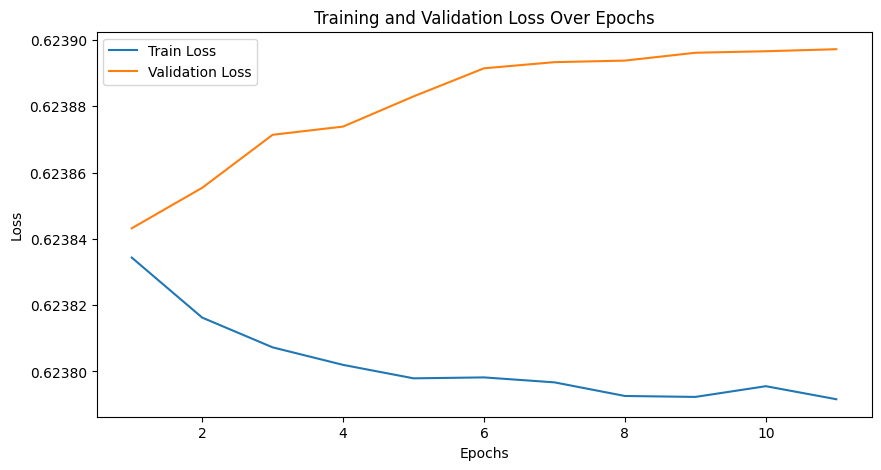

In [9]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime  # For timestamping

# =========================
# Hyperparameters Configuration
# =========================
config = {
    # Model Parameters
    'model': 'LSTM',                # Model type: 'LSTM' or 'MultiLSTM'
    'hidden_size': 256,                  # Number of hidden units in LSTM
    'num_layers': 5,                     # Number of LSTM layers
    'input_format': 'original_and_intervened_inplace',  # Input format for the model

    # Training Parameters
    'learning_rate': 0.0001,              # Learning rate for optimizer
    'weight_decay': 1e-5,                # Weight decay (L2 regularization)
    'batch_size': 64,                    # Batch size for training
    'epochs': 20,                        # Number of training epochs
    'max_interventions': 10,             # Maximum number of interventions per trajectory

    # Intervention Policy
    'intervention_policy_train': 'ucp',  # Policy for training interventions
    'intervention_policy_validate': 'ucp',  # Policy for validation interventions

    # Device Configuration
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # Automatically select 'cuda' if available

    # Data Generation Parameters
    'data_generation': {
        'k': 50,             # Number of concepts
        'n_total': 12000,    # Total number of observations (training + validation)
        'n_train': 10000,    # Number of training observations
        'n_val': 2000,       # Number of validation observations
        'J': 5,              # Number of target classes
        'm': 10,             # Number of concept clusters (used only for MultiLSTM)
        'seed': 42,          # Random seed
    },

    # Adapter Configuration
    'adapter_path': None,                # Path to adapter model (set to None if not used)

    # Early Stopping Parameters
    'early_stop_patience': 10,           # Number of epochs with no improvement after which training will be stopped
}

# Set input_size and output_size based on number of concepts (k)
config['input_size'] = config['data_generation']['k']
config['output_size'] = config['data_generation']['k']

# =========================
# Synthetic Data Generation
# =========================
def generate_synthetic_data(k: int, n: int, J: int, m: int, seed: int):
    torch.manual_seed(seed)
    predicted_concepts = torch.rand(n, k)
    groundtruth_concepts = (torch.rand(n, k) > 0.5).float()
    cluster_assignments = {cid: [] for cid in range(m)}
    for concept_idx in range(k):
        assigned_cluster = torch.randint(low=0, high=m, size=(1,)).item()
        cluster_assignments[assigned_cluster].append(concept_idx)
    labels = torch.randint(low=0, high=J, size=(n,))
    return predicted_concepts, groundtruth_concepts, cluster_assignments, labels

# =========================
# Intervention Policy
# =========================
def ucp(concepts: torch.Tensor, already_intervened_concepts: torch.Tensor) -> torch.Tensor:
    eps = 1e-8
    importances = 1.0 / (torch.abs(concepts - 0.5) + eps)
    importances[already_intervened_concepts == 1] = -1e10
    return importances

# =========================
# Intervention Function
# =========================
def intervene(concepts: torch.Tensor, already_intervened_concepts: torch.Tensor, groundtruth_concepts: torch.Tensor, intervention_policy, return_selected_concepts: bool=False):
    importances = intervention_policy(concepts, already_intervened_concepts)
    concepts_to_intervene = torch.argmax(importances, dim=1)
    concepts[range(concepts.size(0)), concepts_to_intervene] = groundtruth_concepts[range(concepts.size(0)), concepts_to_intervene]
    already_intervened_concepts[range(concepts.size(0)), concepts_to_intervene] = 1
    if not return_selected_concepts:
        return concepts, already_intervened_concepts
    else:
        return concepts, already_intervened_concepts, concepts_to_intervene
# =========================
# Baseline UCP Corrector Model
# =========================
class BaselineConceptCorrector(nn.Module):
    def __init__(self, input_size: int, output_size: int, input_format: str='original_and_intervened_inplace'):
        super(BaselineConceptCorrector, self).__init__()
        self.input_size = input_size
        self.input_format = input_format

# No initial hidden state needed

    def forward(self, inputs: torch.Tensor, already_intervened_concepts: torch.Tensor, original_predictions: torch.Tensor, hidden):
        if self.input_format == 'original_and_intervened_inplace':
            x = already_intervened_concepts * inputs + (1 - already_intervened_concepts) * original_predictions
        elif self.input_format == 'previous_output':
            x = inputs
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")
        # No realignment, only replace with Groundtruth
        output = already_intervened_concepts * inputs + (1 - already_intervened_concepts) * original_predictions
        return output

    def forward_single_timestep(self, inputs: torch.Tensor, already_intervened_concepts: torch.Tensor, original_predictions: torch.Tensor, hidden, selected_clusters=None, selected_cluster_ids=None):
        inputs = inputs.unsqueeze(1)
        already_intervened_concepts = already_intervened_concepts.unsqueeze(1)
        original_predictions = original_predictions.unsqueeze(1)
        output = self.forward(inputs, already_intervened_concepts, original_predictions)
        output = output.squeeze(1)
        return output
    
# =========================
# LSTM Concept Corrector Model
# =========================
class LSTMConceptCorrector(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int, input_format: str='original_and_intervened_inplace'):
        super(LSTMConceptCorrector, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_format = input_format
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def prepare_initial_hidden(self, batch_size: int, device: torch.device):
        return (
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        )

    def forward(self, inputs: torch.Tensor, already_intervened_concepts: torch.Tensor, original_predictions: torch.Tensor, hidden):
        if self.input_format == 'original_and_intervened_inplace':
            x = already_intervened_concepts * inputs + (1 - already_intervened_concepts) * original_predictions
        elif self.input_format == 'previous_output':
            x = inputs
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")
        lstm_out, hid = self.lstm(x, hidden)
        output = torch.sigmoid(self.fc(lstm_out))
        output = already_intervened_concepts * inputs + (1 - already_intervened_concepts) * output
        return output, hid

    def forward_single_timestep(self, inputs: torch.Tensor, already_intervened_concepts: torch.Tensor, original_predictions: torch.Tensor, hidden, selected_clusters=None, selected_cluster_ids=None):
        inputs = inputs.unsqueeze(1)
        already_intervened_concepts = already_intervened_concepts.unsqueeze(1)
        original_predictions = original_predictions.unsqueeze(1)
        output, hid = self.forward(inputs, already_intervened_concepts, original_predictions, hidden)
        output = output.squeeze(1)
        return output, hid

# =========================
# Multi-Cluster LSTM Concept Corrector Model
# =========================
class MultiLSTMConceptCorrector(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int, m_clusters: int, concept_to_cluster: list, input_format: str='original_and_intervened_inplace'):
        super(MultiLSTMConceptCorrector, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.m_clusters = m_clusters
        self.concept_to_cluster = concept_to_cluster
        self.input_format = input_format
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=len([c for c in range(input_size) if self.concept_to_cluster[c] == cluster_id]),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
            for cluster_id in range(m_clusters)
        ])
        self.fc_layers = nn.ModuleList([
            nn.Linear(
                hidden_size,
                len([c for c in range(input_size) if self.concept_to_cluster[c] == cluster_id])
            )
            for cluster_id in range(m_clusters)
        ])

    def prepare_initial_hidden(self, batch_size: int, device: torch.device):
        hidden_states = []
        for _ in range(self.m_clusters):
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            hidden_states.append((h_0, c_0))
        return hidden_states

    def forward(self, inputs: torch.Tensor, already_intervened_concepts: torch.Tensor, original_predictions: torch.Tensor, hidden_states: list):
        if self.input_format == 'original_and_intervened_inplace':
            x = already_intervened_concepts * inputs + (1 - already_intervened_concepts) * original_predictions
        elif self.input_format == 'previous_output':
            x = inputs
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")
        output = torch.zeros_like(x)
        for cluster_id in range(self.m_clusters):
            cluster_concept_indices = [c for c in range(self.input_size) if self.concept_to_cluster[c] == cluster_id]
            if not cluster_concept_indices:
                continue
            cluster_concepts = x[:, :, cluster_concept_indices]
            lstm_out, hid = self.lstm_layers[cluster_id](cluster_concepts, hidden_states[cluster_id])
            fc_out = torch.sigmoid(self.fc_layers[cluster_id](lstm_out))
            fc_out = already_intervened_concepts[:, :, cluster_concept_indices] * original_predictions[:, :, cluster_concept_indices] + \
                     (1 - already_intervened_concepts[:, :, cluster_concept_indices]) * fc_out
            output[:, :, cluster_concept_indices] = fc_out
            hidden_states[cluster_id] = hid
        return output, hidden_states

    def forward_single_timestep(self, inputs: torch.Tensor, already_intervened_concepts: torch.Tensor, original_predictions: torch.Tensor, hidden_states: list, selected_clusters=None, selected_cluster_ids=None):
        inputs = inputs.unsqueeze(1)
        already_intervened_concepts = already_intervened_concepts.unsqueeze(1)
        original_predictions = original_predictions.unsqueeze(1)
        output, updated_hidden_states = self.forward(
            inputs, already_intervened_concepts, original_predictions, hidden_states
        )
        output = output.squeeze(1)
        return output, updated_hidden_states
    
# =========================
# Trajectory Sampling
# =========================
def sample_trajectory(concept_corrector: nn.Module, concepts: torch.Tensor, groundtruth_concepts: torch.Tensor, initial_hidden, intervention_policy, max_interventions: int, concept_to_cluster: list, model_type: str):
    with torch.no_grad():
        all_inputs = []
        all_masks = []
        all_original_predictions = []
        all_groundtruths = []
        if model_type == 'MultiLSTM':
            hidden_states = initial_hidden
        elif model_type == 'LSTM':
            hidden = initial_hidden
        elif model_type == 'Baseline':
            pass
        already_intervened_concepts = torch.zeros_like(concepts)
        original_predictions = concepts.detach().clone()
        all_inputs.append(concepts.detach().clone())
        all_masks.append(already_intervened_concepts.detach().clone())
        all_original_predictions.append(original_predictions)
        all_groundtruths.append(groundtruth_concepts.detach().clone())
        if model_type == 'MultiLSTM':
            out, hidden_states = concept_corrector.forward_single_timestep(
                concepts, already_intervened_concepts, original_predictions, hidden_states
            )
        elif model_type == 'LSTM':
            out, hidden = concept_corrector.forward_single_timestep(
                concepts, already_intervened_concepts, original_predictions, hidden
            )
        elif model_type == "Baseline":
            out = concept_corrector.forward_single_timestep(
                concepts, already_intervened_concepts, original_predictions
            )
        concepts = out
        for _ in range(max_interventions):
            concepts, already_intervened_concepts = intervene(
                concepts, already_intervened_concepts, groundtruth_concepts, intervention_policy
            )
            all_inputs.append(concepts.detach().clone())
            all_masks.append(already_intervened_concepts.detach().clone())
            all_original_predictions.append(original_predictions)
            all_groundtruths.append(groundtruth_concepts.detach().clone())
            if model_type == 'MultiLSTM':
                intervened = (concepts != original_predictions).float()
                concepts_to_intervene = torch.argmax(intervened, dim=1)
                selected_clusters = torch.tensor([concept_to_cluster[c.item()] for c in concepts_to_intervene]).to(concepts.device)
                unique_clusters = torch.unique(selected_clusters)
                out, hidden_states = concept_corrector.forward_single_timestep(
                    concepts, already_intervened_concepts, original_predictions, hidden_states, selected_clusters, unique_clusters.tolist()
                )
                concepts = out
            elif model_type == 'LSTM':
                out, hidden = concept_corrector.forward_single_timestep(
                    concepts, already_intervened_concepts, original_predictions, hidden
                )
                concepts = out
            elif model_type == 'Baseline':
                out = concept_corrector.forward_single_timestep(
                    concepts, already_intervened_concepts, original_predictions
                )
        all_inputs = torch.stack(all_inputs, dim=1)
        all_masks = torch.stack(all_masks, dim=1)
        all_original_predictions = torch.stack(all_original_predictions, dim=1)
        all_groundtruths = torch.stack(all_groundtruths, dim=1)
        if torch.min(all_inputs) < 0 or torch.max(all_inputs) > 1:
            print("Warning: All inputs have values outside the [0, 1] range.")
        return all_inputs, all_masks, all_original_predictions, all_groundtruths

# =========================
# Loss Computation
# =========================
def compute_loss(concept_corrector: nn.Module, concepts: torch.Tensor, groundtruth_concepts: torch.Tensor, initial_hidden, intervention_policy, max_interventions: int, criterion, concept_to_cluster: list, model_type: str):
    all_inputs, all_masks, all_original_predictions, all_groundtruths = sample_trajectory(
        concept_corrector, concepts, groundtruth_concepts, initial_hidden, intervention_policy, max_interventions, concept_to_cluster, model_type
    )
    if model_type == 'MultiLSTM':
        hidden_states = concept_corrector.prepare_initial_hidden(all_inputs.size(0), all_inputs.device)
        out, _ = concept_corrector.forward(all_inputs, all_masks, all_original_predictions, hidden_states)
    elif model_type == 'LSTM':
        out, _ = concept_corrector.forward(all_inputs, all_masks, all_original_predictions, None)
    elif model_type == 'Baseline':
        out = concept_corrector.forward(all_inputs,all_masks, all_original_predictions)
    return criterion(out, all_groundtruths)

# =========================
# Data Preparation and Splitting
# =========================
def ensure_all_classes(train_labels: torch.Tensor, J: int) -> bool:
    unique_classes = torch.unique(train_labels)
    return len(unique_classes) == J

def prepare_datasets(config: dict):
    data_gen_params = config['data_generation']
    k = data_gen_params['k']
    n_total = data_gen_params['n_total']
    n_train = data_gen_params['n_train']
    n_val = data_gen_params['n_val']
    J = data_gen_params['J']
    m = data_gen_params['m']
    seed = data_gen_params['seed']
    for attempt in range(1, 6):
        all_pred, all_gt, all_clusters, all_labels = generate_synthetic_data(k, n_total, J, m, seed + attempt)
        train_pred = all_pred[:n_train]
        train_gt = all_gt[:n_train]
        train_labels = all_labels[:n_train]
        val_pred = all_pred[n_train:n_train + n_val]
        val_gt = all_gt[n_train:n_train + n_val]
        val_labels = all_labels[n_train:n_train + n_val]
        if ensure_all_classes(train_labels, J):
            print(f"Data generation successful on attempt {attempt}.")
            break
        else:
            print(f"Attempt {attempt}: Not all classes present in training data. Regenerating...")
    else:
        raise ValueError("Failed to generate training data with all classes present after multiple attempts.")
    train_dataset = TensorDataset(
        train_pred.float(),
        train_gt.float()
    )
    val_dataset = TensorDataset(
        val_pred.float(),
        val_gt.float()
    )
    concept_to_cluster = [0] * k
    for cluster_id, concept_indices in all_clusters.items():
        for c in concept_indices:
            concept_to_cluster[c] = cluster_id
    return train_dataset, val_dataset, concept_to_cluster

# =========================
# Prepare DataLoaders
# =========================
def prepare_dataloaders(train_dataset: TensorDataset, val_dataset: TensorDataset, batch_size: int):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# =========================
# Main Training Loop
# =========================
def main():
    device = config['device']
    print(f"Using device: {device}")
    train_dataset, val_dataset, concept_to_cluster = prepare_datasets(config)
    train_loader, val_loader = prepare_dataloaders(
        train_dataset, val_dataset, config['batch_size']
    )
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    model_type = config['model']
    print(f"Selected model type: {model_type}")
    if model_type == 'MultiLSTM':
        ConceptCorrectorClass = MultiLSTMConceptCorrector
        concept_corrector = ConceptCorrectorClass(
            input_size=config['input_size'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            output_size=config['output_size'],
            m_clusters=config['data_generation']['m'],
            concept_to_cluster=concept_to_cluster,
            input_format=config['input_format']
        ).to(device)
    elif model_type == 'LSTM':
        ConceptCorrectorClass = LSTMConceptCorrector
        concept_corrector = ConceptCorrectorClass(
            input_size=config['input_size'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            output_size=config['output_size'],
            input_format=config['input_format']
        ).to(device)
    elif model_type == 'Baseline':
        ConceptCorrectorClass = BaselineConceptCorrector
        concept_corrector = ConceptCorrectorClass(
            input_size=config['input_size'],
            output_size=config['output_size'],
            input_format=config['input_format']
        ).to(device)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    print(f"{model_type} model initialized.")
    for name, param in concept_corrector.named_parameters():
        if 'weight' in name and param.ndimension() >= 2:
            nn.init.xavier_uniform_(param)
        elif 'bias' in name:
            nn.init.constant_(param, 0.0)
    print("Model weights initialized.")
    adapter = None
    if config['adapter_path'] is not None:
        if os.path.exists(config['adapter_path']):
            adapter = torch.load(config['adapter_path']).to(device)
            print(f"Using adapter from: {config['adapter_path']}")
        else:
            raise FileNotFoundError(f"Adapter path {config['adapter_path']} does not exist.")
    else:
        print("No adapter path provided. Skipping adapter loading.")
    # =========================
    # No Training for Baseline
    # =========================
    if model_type != 'Baseline':
        optimizer = optim.Adam(
            concept_corrector.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        print("Optimizer and scheduler initialized.")
    else:
        optimizer = None
        scheduler = None
        print("Skipping optimizer and scheduler for Baseline model")
    criterion = nn.BCELoss()
    print("Loss function initialized.")
    best_val_loss = float('inf')
    early_stop_counter = 0
    early_stop_patience = config['early_stop_patience']
    train_losses = []
    val_losses = []
    trained_models_dir = os.path.join('trained_models')
    os.makedirs(trained_models_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_model_filename = f"best_model_{model_type}_{timestamp}.pth"
    final_model_path = os.path.join(trained_models_dir, final_model_filename)
    for epoch in range(1, config['epochs'] + 1):
        start_time = time.time()
        concept_corrector.train()
        train_loss = 0.0
        if model_type != 'Baseline':
            for batch in train_loader:
                predicted_concepts, groundtruth_concepts = [b.to(device) for b in batch]
                optimizer.zero_grad()
                if model_type == 'MultiLSTM':
                    initial_hidden = concept_corrector.prepare_initial_hidden(predicted_concepts.size(0), device)
                else:
                    initial_hidden = concept_corrector.prepare_initial_hidden(predicted_concepts.size(0), device)
                if adapter is not None:
                    predicted_concepts, _ = adapter.forward_single_timestep(
                        predicted_concepts, torch.zeros_like(predicted_concepts), predicted_concepts, initial_hidden
                    )
                loss = compute_loss(
                    concept_corrector,
                    predicted_concepts,
                    groundtruth_concepts,
                    initial_hidden,
                    ucp,
                    config['max_interventions'],
                    criterion,
                    concept_to_cluster,
                    model_type
                )
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            scheduler.step()
            average_train_loss = train_loss / len(train_loader)
            train_losses.append(average_train_loss)
            concept_corrector.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    predicted_concepts, groundtruth_concepts = [b.to(device) for b in batch]
                    if model_type == 'MultiLSTM':
                        initial_hidden = concept_corrector.prepare_initial_hidden(predicted_concepts.size(0), device)
                    elif model_type == 'LSTM':
                        initial_hidden = concept_corrector.prepare_initial_hidden(predicted_concepts.size(0), device)
                    elif model_type == 'Baseline':
                        pass
                    if adapter is not None:
                        predicted_concepts, _ = adapter.forward_single_timestep(
                            predicted_concepts, torch.zeros_like(predicted_concepts), predicted_concepts, initial_hidden
                        )
                    loss = compute_loss(
                        concept_corrector,
                        predicted_concepts,
                        groundtruth_concepts,
                        initial_hidden,
                        ucp,
                        config['max_interventions'],
                        criterion,
                        concept_to_cluster,
                        model_type
                    )
                    val_loss += loss.item()
            average_val_loss = val_loss / len(val_loader)
            val_losses.append(average_val_loss)
            if average_val_loss < best_val_loss:
                best_val_loss = average_val_loss
                early_stop_counter = 0
                print(f"Epoch {epoch}: Improved validation loss to {best_val_loss:.4f}.")
            else:
                early_stop_counter += 1
                print(f"Epoch {epoch}: Validation loss did not improve ({average_val_loss:.4f}).")
            epoch_time = time.time() - start_time
            print(f"Epoch [{epoch}/{config['epochs']}], "
                f"Train Loss: {average_train_loss:.4f}, "
                f"Val Loss: {average_val_loss:.4f}, "
                f"Time: {epoch_time:.2f}s")
            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break
    torch.save(concept_corrector.state_dict(), final_model_path)
    print(f"Best model saved to {final_model_path}")
    print("Training completed.")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

if __name__ == '__main__':
    main()